In [1]:
%matplotlib notebook
import os

jplus_dir         =  '/home/CEFCA/aaorsi/work/j-plus/'
elg_analysis_dir  = '/home/CEFCA/aaorsi/work/elg_jplus/'
elgdata           = '%s/out/elgs.dat' % elg_analysis_dir
redmapper_dir     = '/home/CEFCA/aaorsi/work/redmapper/'
redmapperdata     = redmapper_dir + 'redmapper_dr8_public_v6.3_catalog.fits'
tilesdata         = '%s/tiles/tiles_data_new.tsv' % elg_analysis_dir


cwd = os.getcwd()
import sys

sys.path.append(jplus_dir)
sys.path.append(elg_analysis_dir)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits

import jplus
#import elg_analysis as elg
import elgtools as tools_elg
import learn_elgs as learn_elg
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

tile_scale = 1.40

rmin = -2
rmax =np.log10(tile_scale/2.)
nbins = 20

rarr = np.linspace(rmin, rmax, nbins)
dr = rarr[1] - rarr[0]

t_info = np.loadtxt(tilesdata)
print 'tiles info read'



/home/CEFCA/aaorsi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


tiles info read


In [2]:
def get_distance(ra1, dec1, ra2, dec2):
  ra1 *= np.pi/180.
  ra2 *= np.pi/180.
  dec1 *= np.pi/180.
  dec2 *= np.pi/180.
  
# Angular distance for two sets of coordinates
  cosg = (np.cos(np.pi/2. - dec1)*np.cos(np.pi/2. - dec2) +
          np.sin(np.pi/2. - dec1)*np.sin(np.pi/2.-dec2)*np.cos(ra1 - ra2))
  
  return np.arccos(cosg)


def quick_dist(ra1, dec1, ra2, dec2, units='deg'):
  return np.sqrt( ((ra1 - ra2)*np.cos(dec1*np.pi/180))**2 + (dec1 - dec2)**2)

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees


def skydist(ra1,dec1,ra2,dec2, units='deg'):
  
  n2 = len(ra2)

  if n2 != len(dec2):
    raise ValueError('ra, dec arrays have different number of elements')
  
  dist = np.zeros(n2)

  c1 = SkyCoord(ra1,dec1,unit=units)
  for i in range(n2):
    c2 = SkyCoord(ra2[i], dec2[i], unit=units)
    dist[i] = c1.separation(c2).radian

  return dist

def load_catalogues(elgfile = elgdata, centralobj = redmapperdata, centralobjtype = 'fits', 
                    zrange=[.3,.35]):


# Function to load elgs and redmapper catalogues

  elgs = pickle.load(open(elgfile))
  print 'ELG catalogue loaded'

  if centralobjtype == 'fits':
    raw_central = fits.open(centralobj)
    central0     = raw_central[1].data
    zsel = np.where((central0['z_lambda'] > zrange[0]) & (central0['z_lambda'] < zrange[1]))[0]
    ncentral = len(zsel)
    central = central0[zsel]
  else:
    central = centralobj
    ncentral = len(central['ra'])
    zsel     = np.arange(ncentral)

  
  return {'elgs':elgs, 'central':central}

  
def get_density(datadic, tileinfo=True):  
  
  gal_arr = np.zeros(nbins)
  central = datadic['central']
  elgs    = datadic['elgs']
  ncentral  = len(central['ra'])
  nelgs    = len(elgs)
    
  #dfunc = quick_dist  # Define which distance calculator to use
  dfunc = haversine_dist # get_distance  # Define which distance calculator to use
  
  print 'central objects loaded, %d clusters' % ncentral

  # Select only those central objects 
  # near a J-PLUS tile
  
  
  elgtiles = np.unique(elgs['tile_id'])
        
  ntiles = len(elgtiles)
  print 'ELG sample is contained in %d tiles' % ntiles
  print 'scanning tiles..'
 
  ktot = 0
  for i in range(ncentral):
    idc = i

    dist = dfunc(central['ra'][idc], central['dec'][idc], t_info[:,1], 
                t_info[:,2])
    idist = np.argmin(dist)
    mindist = dist[idist]
    
    if mindist < tile_scale:
      idtt = np.where(elgtiles == t_info[idist,0])[0]
      
      if len(idtt) != 1:
        continue

      sel_tile = np.where(elgs['tile_id'] == t_info[idist,0])[0]
      ngals = len(sel_tile)
  
      ktot += 1

      for k in range(ngals):
        idg = sel_tile[k]
        dist = np.log10(dfunc(central['ra'][idc], central['dec'][idc], 
        elgs['coords'][idg,0], elgs['coords'][idg,1]))

        if dist < rmax:
          dbin = int((dist  - rmin)/dr)
          gal_arr[dbin:] += 1

#    if ktot == 79:
#      break

  print gal_arr/ktot

  print 'N centers: ',ktot
  return gal_arr/ktot


def plot_densities(d1,label):
  import matplotlib.pyplot as plt
  vol_r = 1 #np.pi*(10**rarr)**2

  for d, l in zip(d1, label):
      plt.semilogy(rarr, d/vol_r,label=l,linewidth=3)

  plt.legend(fontsize=20)

  plt.xlabel(r'$\log(\theta [{\rm deg}])$',fontsize=20)
  plt.ylabel(r'$\langle n \rangle (\leq r) [{\rm deg}^{-2}]$',fontsize=20)

  plt.xlim([rarr.min(),rarr.max()])
  #plt.ylim([np.min([d1v,d2v]), d2v.max()])

  plt.show()

  return 1


In [3]:

#def elg_clusters():

mastercat = load_catalogues()
tcenter = {'ra':t_info[:,1], 'dec':t_info[:,2]}
tilecat = load_catalogues(centralobj=tcenter, centralobjtype='')


elgs = mastercat['elgs']
import pymangle

tiles = jplus.datasets.fetch_jplus_tile_list(upad=False,overwrite=False)
stars = jplus.datasets.fetch_jplus_objects_to_mask(overwrite=False)
mask  = jplus.mangle.Mask(tiles,stars, overwrite=False)
ran = mask.create_random(5e4)
good = mask.contains(elgs['coords'])

nran = len(ran['coords'])
ran_tile_id = np.zeros(nran)
for i in range(nran):
    rc = ran['coords']
    dist = haversine_dist(rc[i,0], rc[i,1], t_info[:,1], 
                t_info[:,2])
    idist = np.argmin(dist)
    mindist = dist[idist]
    ran_tile_id[i] = t_info[idist,0]


randict = {'coords':ran['coords'], 'tile_id':ran_tile_id}    

mask_clusters = {}  # Mask density around ELGs
mask_clusters['elgs'] = randict
mask_clusters['central'] = mastercat['central']


mask_tile = {}
mask_tile['elgs'] = randict
mask_tile['central'] = tilecat['central']


  

j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/work/jplus_data/objects_tile_list_test3_dual.h5
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/work/jplus_data/jplus_objects_to_mask_upad_dual.h5
j-plus [INFO]: Reading Mangle Mask /home/CEFCA/aaorsi/jplus_data/mask_data/jplus_mask.pol
j-plus [INFO]: Creating random points


ELG catalogue loaded
ELG catalogue loaded


j-plus [INFO]: Creating HealPix map
j-plus [INFO]: Saving HealPix map /home/CEFCA/aaorsi/work/jplus_data//hmap_256.fits
j-plus [INFO]: Reading HealPix map /home/CEFCA/aaorsi/work/jplus_data//hmap_256.fits
j-plus [INFO]:  Plotting in the range: lon = [-179.997445068,173.276598638], and lat = [1.14779911088,79.8822481414]


<IPython.core.display.Javascript object>


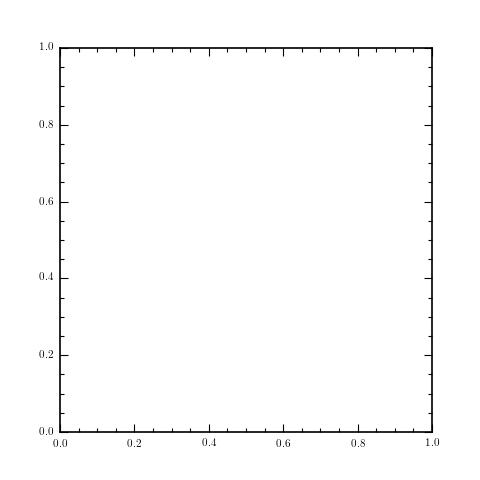

<IPython.core.display.Javascript object>


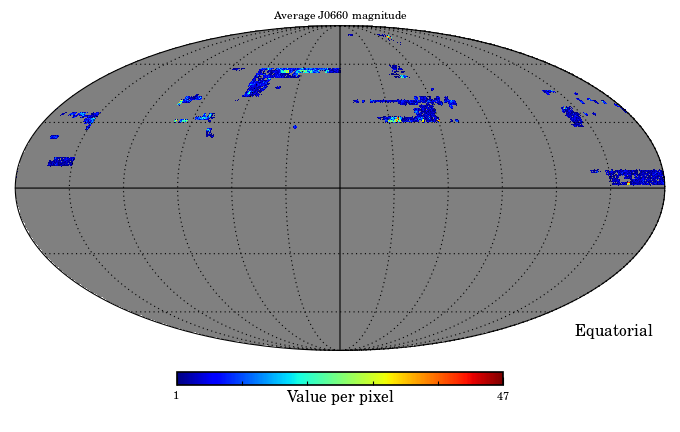

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [39]:
hp = jplus.healpix.HealpixMap(elgs['coords'][:,:], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

j-plus [INFO]: Creating HealPix map
j-plus [INFO]: Saving HealPix map /home/CEFCA/aaorsi/work/jplus_data//hmap_256.fits
j-plus [INFO]: Reading HealPix map /home/CEFCA/aaorsi/work/jplus_data//hmap_256.fits
j-plus [INFO]:  Plotting in the range: lon = [-179.987039,179.998207782], and lat = [1.14995078248,79.8813203368]


<IPython.core.display.Javascript object>


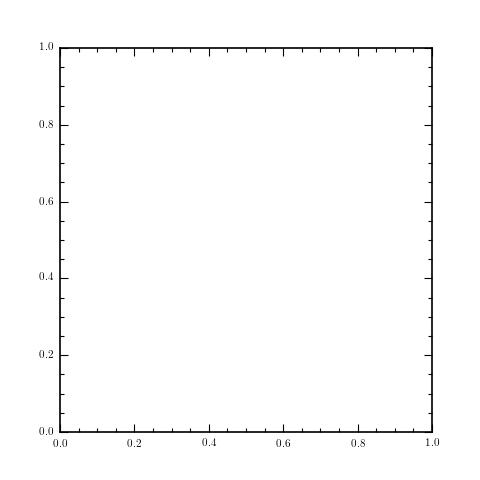

<IPython.core.display.Javascript object>


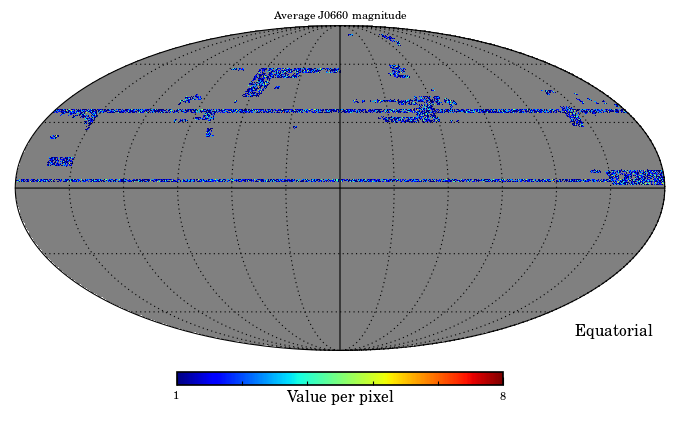

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [40]:
hp = jplus.healpix.HealpixMap(randict['coords'][:,:], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

In [ ]:
print g4

In [ ]:
print mask_clusters['elgs']['tile_id']

In [4]:
g1 = get_density(mastercat)
g2 = get_density(tilecat)

g3 = get_density(mask_clusters)
g4 = get_density(mask_tile)



central objects loaded, 3650 clusters
ELG sample is contained in 524 tiles
scanning tiles..
[  2.53968254e-02   7.30158730e-02   1.52380952e-01   2.34920635e-01
   3.49206349e-01   5.52380952e-01   9.11111111e-01   1.34603175e+00
   2.03174603e+00   2.91428571e+00   4.52063492e+00   6.78730159e+00
   1.01809524e+01   1.50666667e+01   2.23968254e+01   3.29365079e+01
   4.84793651e+01   6.90952381e+01   9.62984127e+01   9.63015873e+01]
N centers:  315
central objects loaded, 6337 clusters
ELG sample is contained in 524 tiles
scanning tiles..
[  6.43745428e-02   1.37527432e-01   2.28237015e-01   4.12338454e-01
   6.81541088e-01   1.02950500e+00   1.63228481e+00   2.38380883e+00
   3.44842721e+00   5.15679103e+00   7.68690563e+00   1.14033163e+01
   1.68061448e+01   2.42511583e+01   3.54813460e+01   5.21285052e+01
   7.55484028e+01   1.07847354e+02   1.49423068e+02   1.49431846e+02]
N centers:  4101
central objects loaded, 3650 clusters
ELG sample is contained in 528 tiles
scanning tiles..

<IPython.core.display.Javascript object>


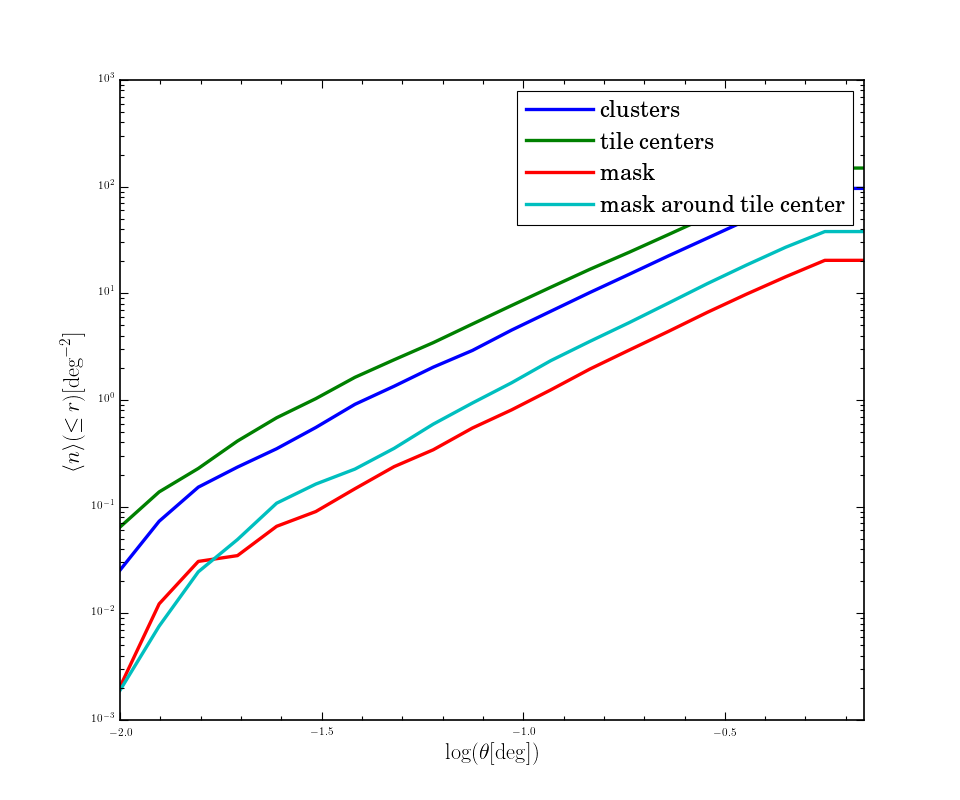

<IPython.core.display.Javascript object>


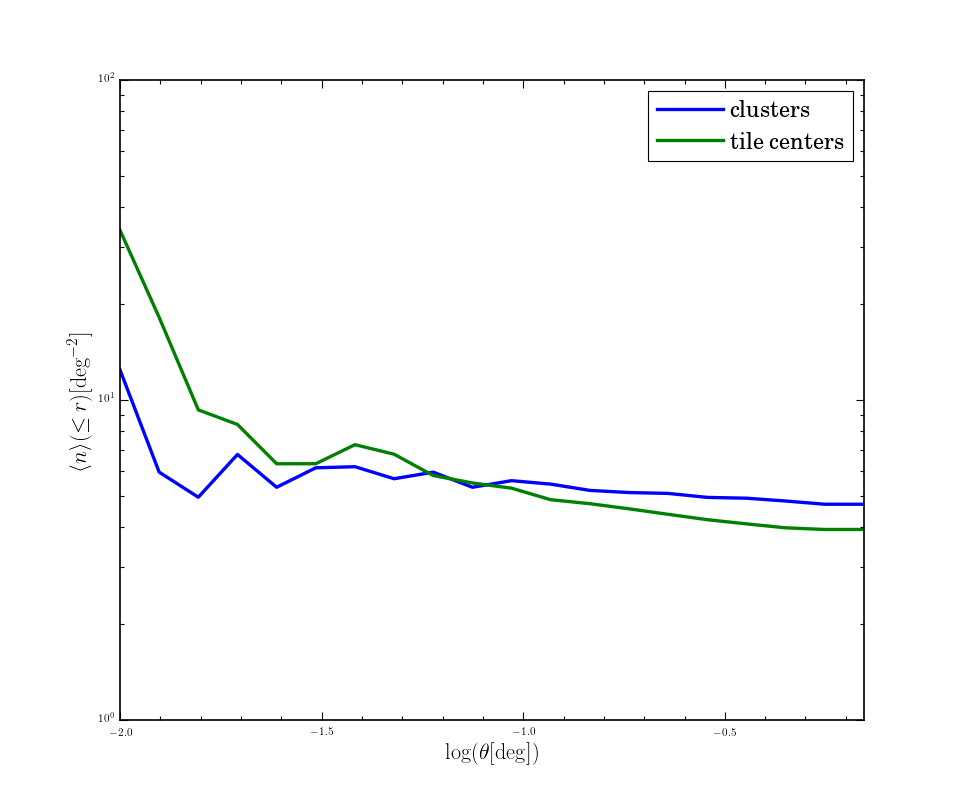

1

In [6]:
plt.figure(2)
plot_densities([g1,g2,g3,g4],['clusters','tile centers', 'mask', 'mask around tile center'])
plt.figure(3)
plot_densities([g1/g3,g2/g4],['clusters','tile centers'])

<IPython.core.display.Javascript object>


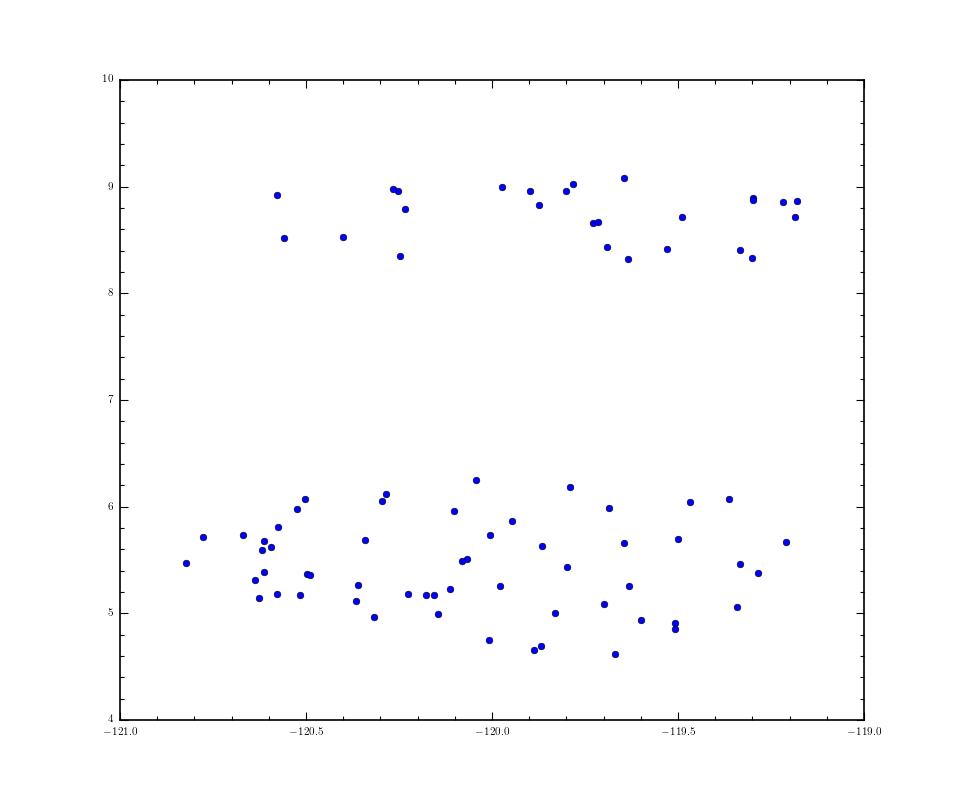

11771.0
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In [36]:
plt.figure()

tnumber = 0
tid = t_info[tnumber,0]
print tid
mask = randict['tile_id'] == randict['tile_id'][0]
print mask[mask == True]
plt.plot(ran['coords'][mask,0]-t_info[tnumber,1],ran['coords'][mask,1]-t_info[tnumber,2],'o')

<IPython.core.display.Javascript object>


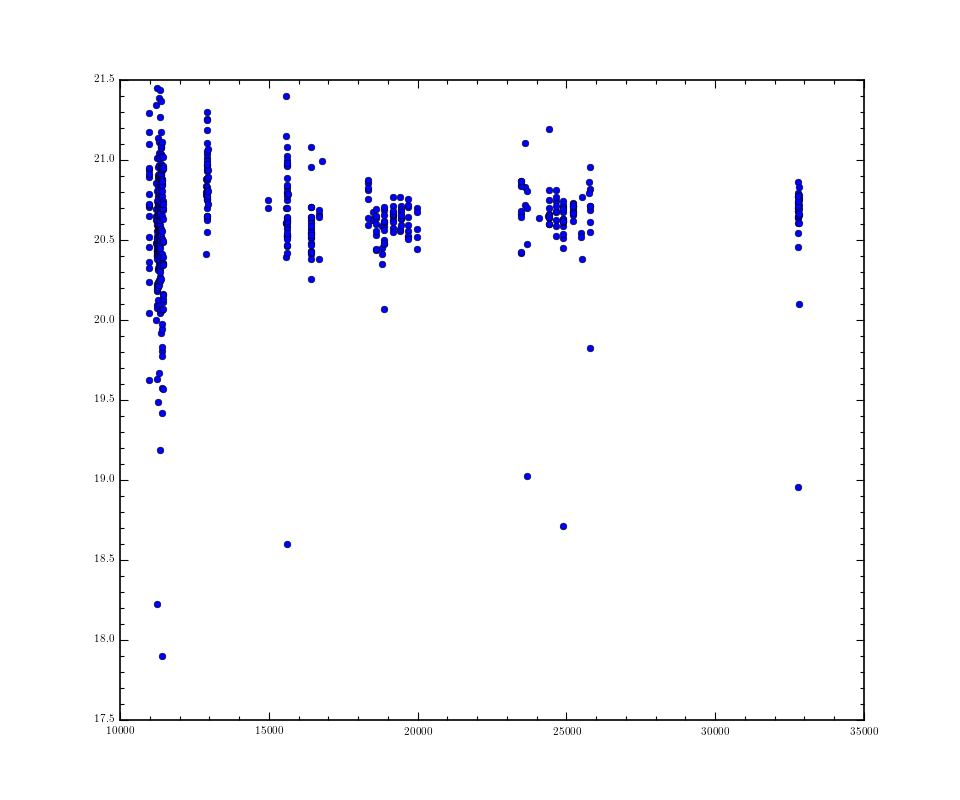

[25778, 32780, 32781, 32782, 32783, 32784, 32785, 32786, 32787, 32788, 32789, 32790, 32791, 32792, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425, 16426, 16427, 16428, 16429, 16430, 16431, 18489, 18490, 18491, 18492, 32804, 25780, 24648, 24649, 24650, 24651, 24652, 24653, 24654, 24655, 24656, 25782, 32793, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18596, 32796, 32797, 32798, 25784, 32800, 32801, 32802, 32803, 25785, 32807, 32808, 32810, 32809, 23594, 23595, 23596, 32811, 19161, 19162, 19163, 24870, 24871, 24872, 19164, 24874, 24875, 24876, 24877, 24878, 24879, 24880, 16689, 16690, 16691, 16692, 19166, 19167, 19168, 19169, 19170, 18817, 18818, 18819, 18820, 16790, 18873, 18874, 18875, 18876, 18877, 18878, 18879, 18880, 18881, 18882, 18883, 18884, 12901, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12918, 12919, 12921, 12922, 12923, 12924, 12925, 12926, 12927

In [19]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
plt.figure()
plt.plot(tile, mag,'o')
print tile, total

In [7]:
elgs[]

{'ISOAREA_WORLD': array([  1.42912654e-07,   3.09644093e-07,   1.90550210e-07, ...,
          2.14368995e-07,   4.52556748e-07,   7.14563271e-08]),
 'J0378': array([[ 21.2105789 ,   0.64624631],
        [ 21.5583458 ,   0.89117312],
        [ 99.        ,  99.        ],
        ..., 
        [ 21.187336  ,   0.39045152],
        [ 21.4928818 ,   0.51344508],
        [ 23.511507  ,   3.24872637]]),
 'J0395': array([[ 24.2586365 ,  11.6207705 ],
        [ 22.2639484 ,   1.85550618],
        [ 99.        ,  99.        ],
        ..., 
        [ 20.0722847 ,   0.16407977],
        [ 20.6631184 ,   0.27063882],
        [ 21.3381424 ,   0.49648043]]),
 'J0410': array([[ 22.3884525 ,   1.83111954],
        [ 99.        ,  99.        ],
        [ 99.        ,  99.        ],
        ..., 
        [ 20.6616573 ,   0.2221306 ],
        [ 21.1022568 ,   0.33240068],
        [ 22.1937733 ,   0.88269079]]),
 'J0430': array([[ 24.4641724 ,  10.6113749 ],
        [ 23.3430557 ,   3.75978565],
        